In [5]:
import pandas as pd
from bert_score import score
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
file_path = "Chandrasekhar_Human_Evaluation_Questions_GPT4o.xlsx"
df = pd.read_excel(file_path)
df = df.dropna(subset=["Human Provided Response", "gpt-4o (OpenAI) Response"])
df.head()

,Question Number,Question Text,Human Provided Response,gpt-4o (OpenAI) Response,Time Taken (Sec)
0,1.0,How do I get admitted to the Master’s in Data ...,https://datascience.unt.edu/programs/msds/admi...,To get admitted to the MTo get admitted to the...,7.80
1,2.0,How can I change my major?,"If admitted to another program, say Computer S...","To change your major at UNT, you should follow...",7.32
2,3.0,What are my course options?,Some freedom to choose guided electives. Stude...,"Your course options, as outlined in the provid...",8.80
3,4.0,What are my degree requirements?,https://datascience.unt.edu/programs/msds/degr...,1. Ensure you are in good academic standing an...,6.08
4,5.0,Can I take all online courses as an internatio...,Students with an F1 visa type cannot. Depends ...,"As an international student, you may have the ...",5.93


In [7]:
human_responses = df["Human Provided Response"].astype(str).tolist()
gpt_responses = df["gpt-4o (OpenAI) Response"].astype(str).tolist()

P, R, F1 = score(gpt_responses, human_responses, lang="en", verbose=True)

# Add to DataFrame
df["BERTScore_Precision"] = P.tolist()
df["BERTScore_Recall"] = R.tolist()
df["BERTScore_F1"] = F1.tolist()

d:\#Code\VS Code\ASKME\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chand\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For bet

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

done in 0.88 seconds, 15.84 sentences/sec


In [8]:
model = SentenceTransformer("all-MiniLM-L6-v2")
emb_human = model.encode(human_responses, convert_to_tensor=True)
emb_gpt = model.encode(gpt_responses, convert_to_tensor=True)

cosine_scores = util.cos_sim(emb_gpt, emb_human).diagonal()
df["SBERT_Cosine_Similarity"] = cosine_scores.tolist()

d:\#Code\VS Code\ASKME\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chand\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regu

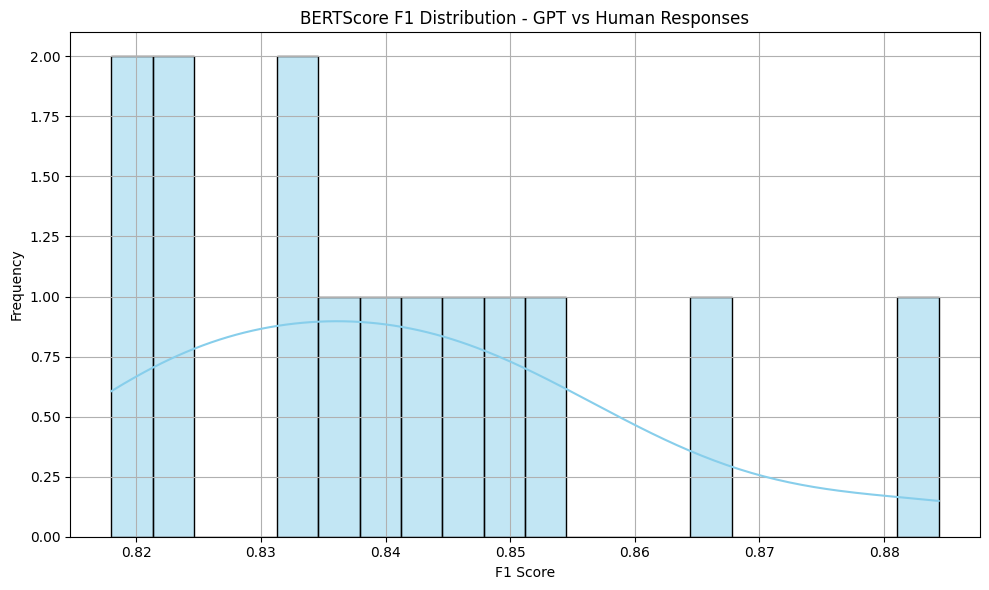

In [9]:
# STEP 6: Visualize BERTScore Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["BERTScore_F1"], kde=True, bins=20, color='skyblue')
plt.title("BERTScore F1 Distribution - GPT vs Human Responses")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import os

# Create the directory if it doesn't exist
os.makedirs("metrics", exist_ok=True)

# Save the file
output_file = "metrics/Evaluation_Scored.xlsx"
df.to_excel(output_file, index=False)
print(f" Evaluation scores saved to: {output_file}")

 Evaluation scores saved to: metrics/Evaluation_Scored.xlsx


In [13]:
# STEP 8: Classify Responses Based on Similarity Thresholds
def classify_hallucination(f1_score, cosine_sim, threshold_f1=0.85, threshold_cosine=0.8):
    if f1_score >= threshold_f1 and cosine_sim >= threshold_cosine:
        return "Factual"
    elif (f1_score >= 0.6 and cosine_sim >= 0.6):
        return "Partially Factual"
    else:
        return "Possible Hallucination"

# Apply classification
df["Hallucination_Label"] = df.apply(lambda row: classify_hallucination(row["BERTScore_F1"], row["SBERT_Cosine_Similarity"]), axis=1)


C:\Users\chand\AppData\Local\Temp\ipykernel_21516\4064307425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Hallucination_Label", palette="Set2")


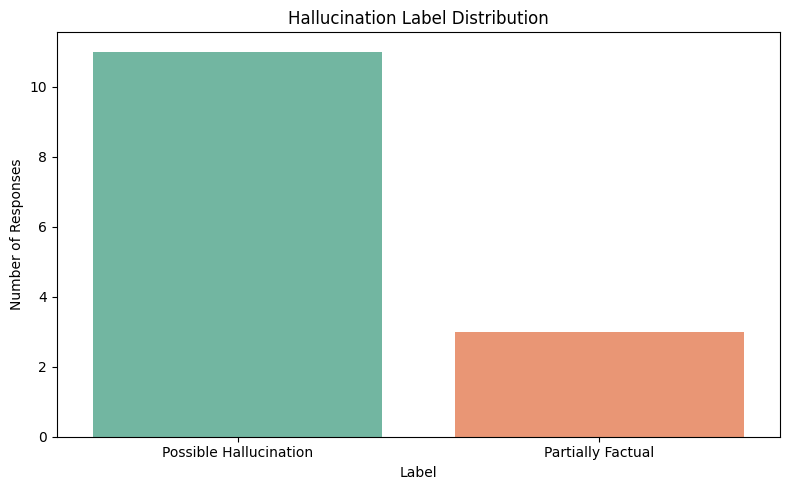

In [14]:
# Distribution of Hallucination Labels
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Hallucination_Label", palette="Set2")
plt.title("Hallucination Label Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Responses")
plt.tight_layout()
plt.show()


In [15]:
#Save updated file
df.to_excel("../../output/Evaluation_Scored_With_Hallucination_Tags.xlsx", index=False)
print("✅ Updated file with hallucination labels saved.")

✅ Updated file with hallucination labels saved.


### Compare Rerank vs Vector Performance

In [16]:
import numpy as np

# Simulate: Assign half responses to Vector and half to Rerank
np.random.seed(42)
df["Mode"] = np.random.choice(["Vector", "Rerank"], size=len(df))

In [17]:
# Group and calculate average similarity scores
comparison_df = df.groupby("Mode")[["BERTScore_F1", "SBERT_Cosine_Similarity"]].mean().reset_index()
comparison_df


,Mode,BERTScore_F1,SBERT_Cosine_Similarity
0,Rerank,0.849580,0.574282
1,Vector,0.838441,0.488874


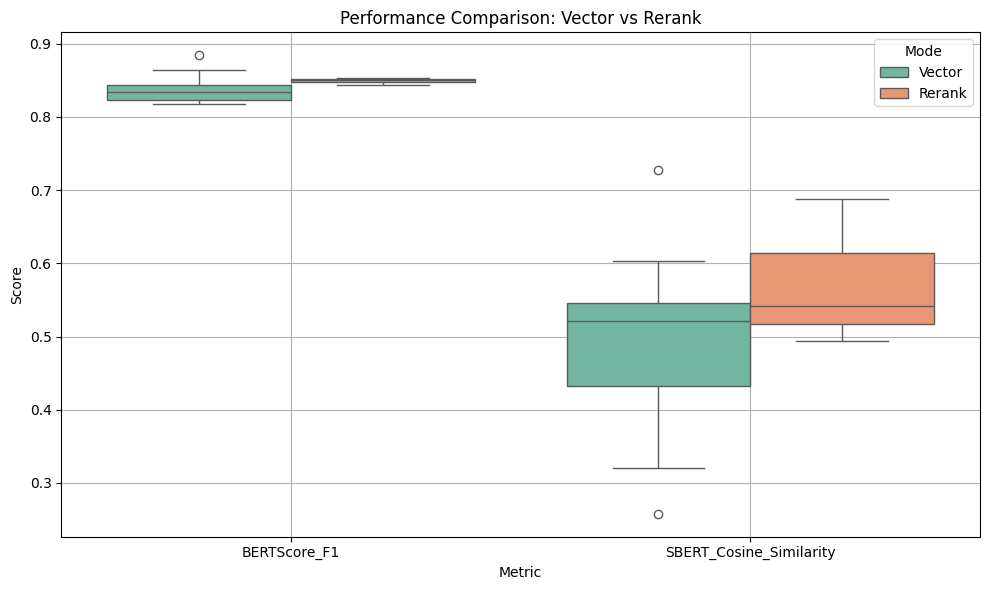

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot comparison side-by-side
melted = df.melt(id_vars="Mode", value_vars=["BERTScore_F1", "SBERT_Cosine_Similarity"],
                 var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Metric", y="Score", hue="Mode", data=melted, palette="Set2")
plt.title("Performance Comparison: Vector vs Rerank")
plt.grid(True)
plt.tight_layout()
plt.show()

### Time vs Accuracy Analysis

<Axes: xlabel='Time Taken (Sec)', ylabel='BERTScore_F1'>

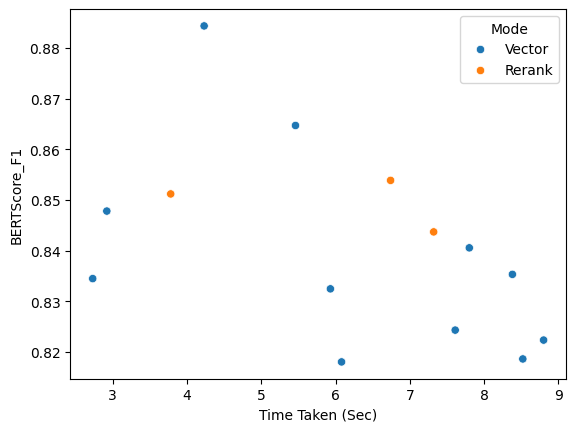

In [19]:
sns.scatterplot(data=df, x="Time Taken (Sec)", y="BERTScore_F1", hue="Mode")

### Top N Best vs Worst Answers

In [20]:
top_5 = df.sort_values("BERTScore_F1", ascending=False).head(5)
worst_5 = df.sort_values("BERTScore_F1", ascending=True).head(5)

### Response Length vs Accuracy

<Axes: xlabel='GPT_Length', ylabel='BERTScore_F1'>

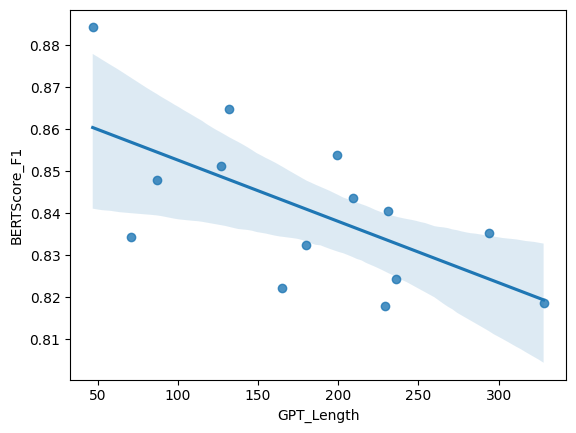

In [21]:
df["GPT_Length"] = df["gpt-4o (OpenAI) Response"].str.split().str.len()
sns.regplot(x="GPT_Length", y="BERTScore_F1", data=df)

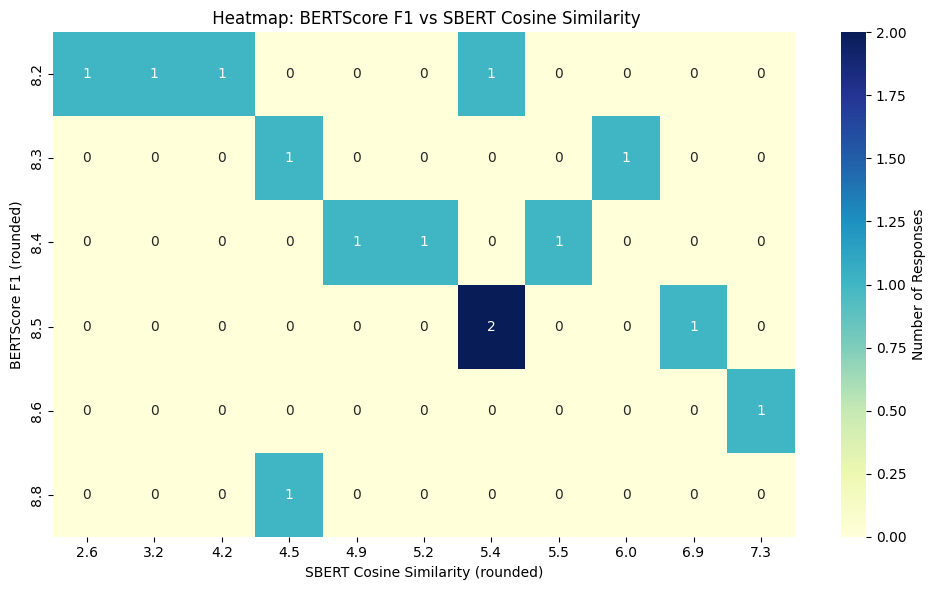

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Round values to create bins for heatmap grouping
df["F1_Rounded"] = (df["BERTScore_F1"] * 10).round(1)  # scale to 0.1 intervals
df["Cosine_Rounded"] = (df["SBERT_Cosine_Similarity"] * 10).round(1)

# Create pivot table
heatmap_data = df.pivot_table(
    index="F1_Rounded",
    columns="Cosine_Rounded",
    values="Question Text",  # any column to count occurrences
    aggfunc="count",
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='d', cbar_kws={'label': 'Number of Responses'})
plt.title(" Heatmap: BERTScore F1 vs SBERT Cosine Similarity")
plt.xlabel("SBERT Cosine Similarity (rounded)")
plt.ylabel("BERTScore F1 (rounded)")
plt.tight_layout()
plt.show()


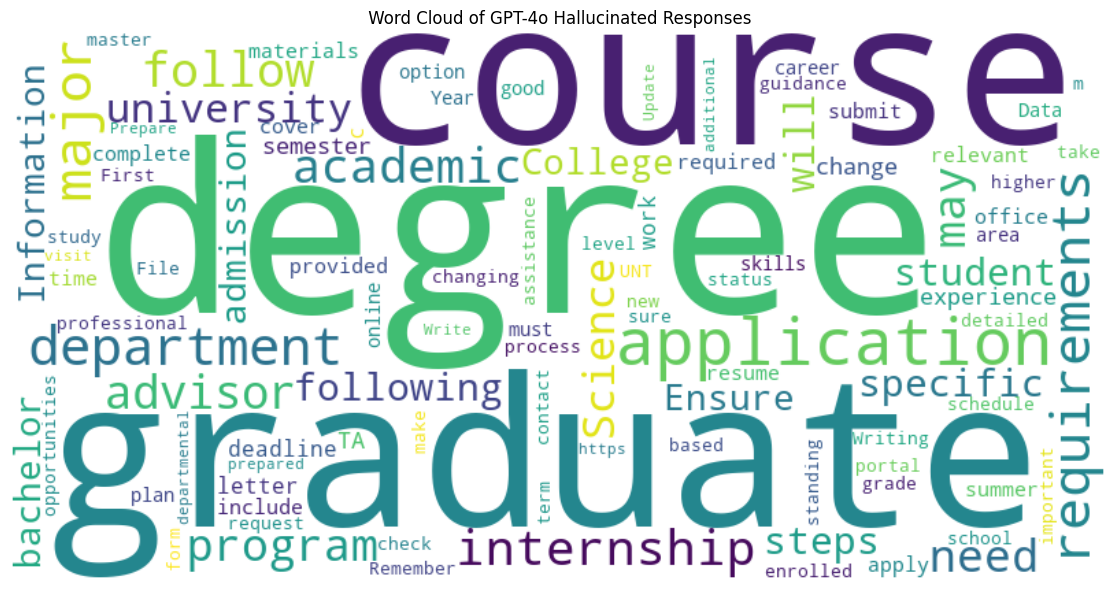

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter responses labeled as hallucinations
hallucinated_responses = df[df["Hallucination_Label"] == "Possible Hallucination"]["gpt-4o (OpenAI) Response"]

# Combine all text into one string
text_blob = " ".join(hallucinated_responses.astype(str).tolist())

# Create the word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100,
    collocations=False
).generate(text_blob)

# Plot it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(" Word Cloud of GPT-4o Hallucinated Responses")
plt.tight_layout()
plt.show()


In [24]:
# Factual responses for comparison
factual_text = " ".join(df[df["Hallucination_Label"] == "Factual "]["gpt-4o (OpenAI) Response"].astype(str))
